# How to create a **edges file** from email data to **visualize in gephi**

Read the data from the enron email dataset

In [69]:
import pandas as pd
import datetime
MAILFILE = "emails.csv"; DESTFILE = "enron_edges.csv"; ROWS = 10000
FROM = "From: "; TO = "To: "; from2toids = []
print("starting edge file generation {} ({}) - {}".format(MAILFILE, ROWS, tic))
tic = datetime.datetime.now()
df = pd.read_csv(MAILFILE, nrows = ROWS)
df[0:2]

starting edge file generation emails.csv (10000) - 2019-12-04 04:08:39.260476


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...


Extract the From & To from each email. Count the number of times a combination of **From --> To** occurs

In [70]:
for i in range(ROWS):
    message = df['message'].values[i]
    lines = message.splitlines()
    for line in lines:
        if line.startswith(FROM): 
            From = line.split(FROM)
            if len(From) > 1:
                From = From[1].strip().lower()
            else:
                From = From[0].strip().lower()
        elif line.startswith(TO):
            To = line.split("To: ")
            if len(To) > 1:
                To = To[1].strip().lower()
            else:
                To = To[0].strip().lower()
    Tos = [item.strip() for item in To.split(",") if item.strip() != ""]
    [from2toids.append(From + " --> " + To) for To in Tos]

from collections import Counter
from2toids_c = Counter(from2toids).most_common(ROWS)
[print(item[0], ":", item[1]) for item in from2toids_c[0:5]]

john.arnold@enron.com --> john arnold/hou/ect@ect : 428
john.arnold@enron.com --> john.arnold@enron.com : 247
phillip.allen@enron.com --> phillip k allen/hou/ect@ect : 202
phillip.allen@enron.com --> stagecoachmama@hotmail.com : 161
phillip.allen@enron.com --> jsmith@austintx.com : 112


[None, None, None, None, None]

Create a graph

In [74]:
import networkx as nx
graph = nx.DiGraph()
[graph.add_edge(ele[0].strip("'").split(" --> ")[0].strip(), ele[0].strip("'").split(" --> ")[1].strip(), 
            weight = ele[1]) for ele in from2toids_c]
print("Graph details ", end = "")
print(len(graph), "Nodes:", graph.number_of_nodes(), "Edges:", graph.number_of_edges(),"Size:", graph.size())
print("Global Clustering Coefficient: {:.3f} Transitivity: {:.3f}".format(nx.average_clustering(graph), 
                                                                            nx.transitivity(graph)))
print("number_strongly_connected_components:", nx.number_strongly_connected_components(graph))
print("number_weakly_connected_components:", nx.number_weakly_connected_components(graph))

Graph details 2720 Nodes: 2720 Edges: 3567 Size: 3567
Global Clustering Coefficient: 0.040 Transitivity: 0.004
number_strongly_connected_components: 2618
number_weakly_connected_components: 174


Get the edge list from the graph and use this to create a pandas dataframe. The edges dataframe will have the columns - source, target, weight. Save the edge dataframe to a csv file. This file can be opened in gephi to visualize the graph

In [72]:
dfemails = nx.to_pandas_edgelist(graph)
print(dfemails[0:2])
dfemails = dfemails.sort_values(['weight'], ascending=False)
dfemails = dfemails[dfemails['weight'] > 10]
print("created a edge file", dfemails.size, DESTFILE)
dfemails.to_csv(DESTFILE, index=False)
toc = datetime.datetime.now()
print("completed edge file generation in {}".format(toc-tic))

                  source                   target  weight
0  john.arnold@enron.com  john arnold/hou/ect@ect     428
1  john.arnold@enron.com    john.arnold@enron.com     247
created a edge file 552 enron_edges.csv
completed edge file generation in 0:00:20.983243


![graph](/media/enron.png)

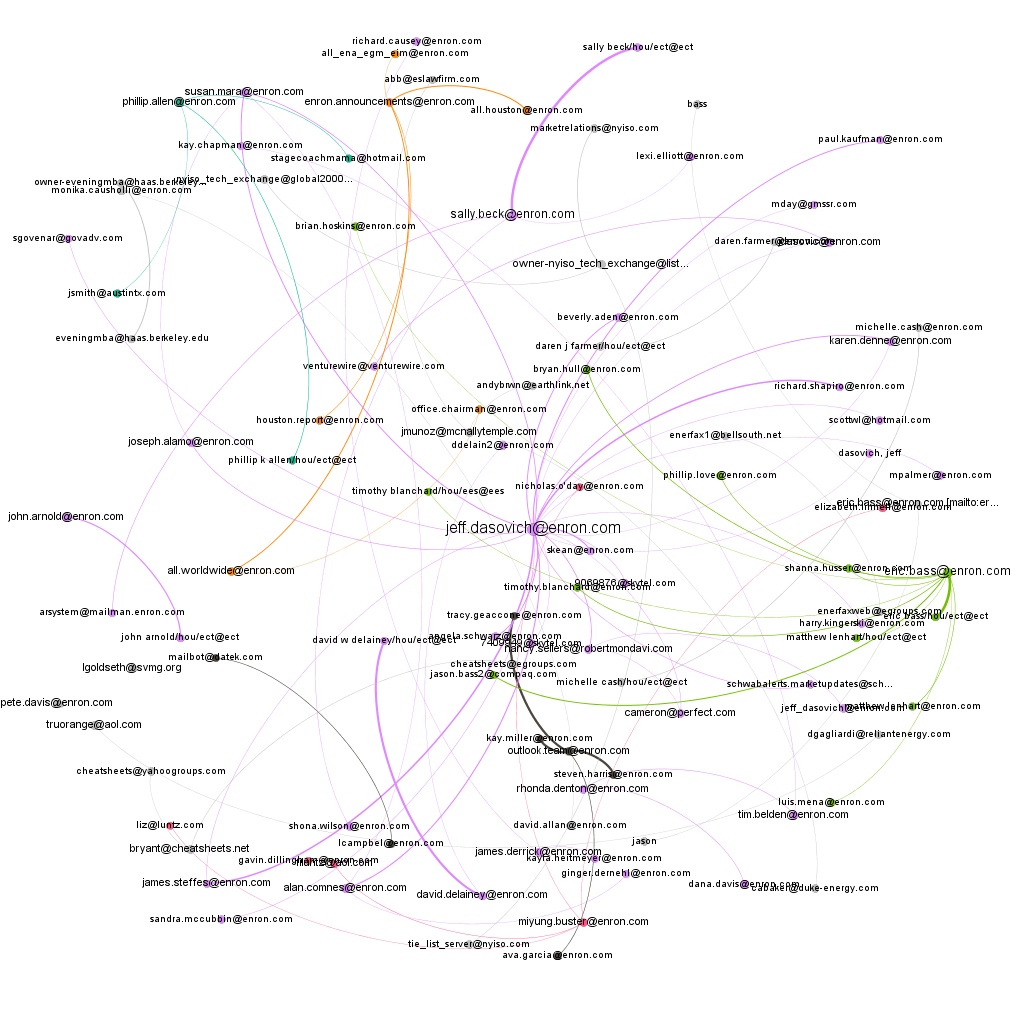

In [61]:
from IPython.display import Image
Image(filename='/media/enron.png') 

Though gephi visuals (i.e. if you manage to work with it) are good, it is buggy and not easy to navigate though. 
*   Most of the times the preview window shows empty screen, but when you export, the graph is saved in the file
*   Filtering is not easy

(-1.1826364925503732,
 1.1778635314106942,
 -1.2048527631163597,
 1.1558314594626427)

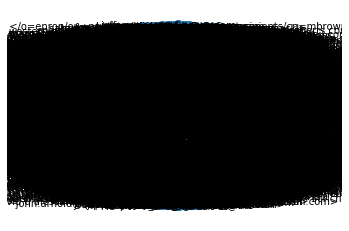

In [73]:
import matplotlib.pyplot as plt
WEIGHT = 100
elarge = [(u, v) for (u, v, d) in graph.edges(data=True) if d['weight'] >= WEIGHT]
esmall = [(u, v) for (u, v, d) in graph.edges(data=True) if d['weight'] < WEIGHT]
#nx.draw_networkx(G)
pos = nx.spring_layout(graph) 
nx.draw_networkx_nodes(graph, pos, node_size=100)
nx.draw_networkx_edges(graph, pos, edgelist=elarge,width=6)
nx.draw_networkx_edges(graph, pos, edgelist=esmall,width=1, alpha=0.5, style='dashed')  # , edge_color='b'
#nx.draw_networkx_edge_labels(G, pos,edge_labels=elarge)
nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')
plt.axis('off')